# Cloud Botany data access: browse, and download a set

See Jansson et al. [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2023MS003796). Also notebook templates and [instructions](https://howto.eurec4a.eu/botany_dales.html). From these I downloaded mean profiles, and time-slice 2D fields of TWP LWP and precipitation. Those downloaded subsamples are analyzed in the other notebook in this directory, whose figures appear in the paper. In the profiles, 'wthvt','w2r' are the w - theta-v covariance (buoyancy flux with some unit conversions) and w variance for a quick vertical KE (VKE) budget residence time. 

Environment: `pip install intake xarray intake-xarray zarr pydap s3fs requests ipfsspec` 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
import xarray as xr

In [3]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")

In [4]:
list(cat)

['radiosondes',
 'barbados',
 'Atalante',
 'ATR',
 'BOREAL',
 'CU-RAAVEN',
 'Caravela',
 'HALO',
 'Humpback',
 'IFM03',
 'IFM09',
 'IFM12',
 'Kracken',
 'Melonhead',
 'mini-MPCK',
 'MPCK-plus',
 'MS-Merian',
 'NTAS',
 'Omura',
 'P3',
 'QuadCopter',
 'RonBrown',
 'SD-1026',
 'SD-1060',
 'SD-1061',
 'SD-1063',
 'SD-1064',
 'Skywalker07',
 'Skywalker10',
 'Skywalker12',
 'SVP-B-4101696',
 'SVP-B-4101697',
 'SVP-B-4101698',
 'SVP-B-4101699',
 'SVP-B-4101780',
 'SVP-BRST-4402505',
 'SVP-BRST-4402506',
 'SVP-BRST-4402507',
 'SVP-BRST-4402508',
 'SVP-BRST-6203717',
 'SVP-BS-4101757',
 'SVP-BS-4101758',
 'SVP-BSW-3101569',
 'SVP-BSW-3101570',
 'SVP-BSW-3101571',
 'SVP-BSW-3101572',
 'SVP-BSW-3101573',
 'SVP-BSW-3101574',
 'SVP-BSW-3101575',
 'SVP-BSW-3101576',
 'SVP-BSW-3101577',
 'SVP-BSW-3101578',
 'SWIFT16',
 'SWIFT17',
 'SWIFT22',
 'SWIFT23',
 'SWIFT24',
 'SWIFT25',
 'TO',
 'WG245',
 'WG247',
 'c3ontext',
 'dropsondes',
 'satellites',
 'simulations',
 'radiative_profiles',
 'Meteor']

In [5]:
# Satellite data from EUREC4A: some other project to look at that ONE MINUTE RES!
# sat = cat.satellites.GOES16.latlongrid.to_dask()
# sat.isel(time=100).plot()     # lat: 2640 lon: 2200 time: 1440 = 1 minute resolution!!

In [6]:
botany_cat = cat.simulations.DALES.botany

In [7]:
botany_cat.dx100m.nx1536

nx1536:
  args:
    path: https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/Simulations/DALES/botany_dx100m_nx1536.yaml
  description: 'Cloud botany: DALES LES ensemble with varied forcings at 100m grid
    spacing, 153.6 km domain'
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/Simulations/DALES


In [8]:
import pandas as pd
varied_parameters = ['member','thls', 'u0', 'qt0', 'qt_lambda', 'thl_Gamma', 'wpamp', 'dudz', 'location']
parameters = cat.simulations.DALES.botany.dx100m.nx1536.parameters.read()
df_parameters = pd.DataFrame.from_records(parameters)[varied_parameters]
df_parameters

ValueError: No plugins loaded for this entry: json
A listing of installable plugins can be found at https://intake.readthedocs.io/en/latest/plugin-directory.html .

In [ ]:
df_parameters.iloc[ [2,9,32,33,34,35,36] ]

In [ ]:
import xarray as xr

ds_profiles = botany_cat.dx100m.nx1536['profiles'].to_dask()
# Add u0 to the profiles output
ds_u = ds_profiles.assign(df_parameters[['member','u0']].set_index('member').to_xarray())

ds_u

In [ ]:
mydata = ds_u[['wthvt','ql','ql2r','cfrac','w2r','u','v']]
mydata.to_netcdf('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany_profilesuv.nc')
mydata 

In [ ]:
# Plot wind profiles 
# Examples from the HowTo https://howto.eurec4a.eu/botany_dales.html#

from cycler import cycler

fig = plt.figure()
ax = plt.gca()
ax.set_prop_cycle(cycler(color=plt.cm.cividis(np.linspace(0, 1, 7))))

# Plot mean cloud fraction profiles grouped by surface wind over the last 100 time steps of all simulations
ds_u[['cfrac','u','v','u0']].isel(time=slice(-100,-1)).sel(zt = slice(0,4000)).mean(dim='time').\
       groupby('u0').mean()['u'].plot.line(ax=ax, y='zt')
(-ds_u[['cfrac','u','v','u0']].isel(time=slice(-100,-1)).sel(zt = slice(0,4000)).mean(dim='time').\
       groupby('u0').mean()['v']).plot.line(ax=ax, y='zt')
plt.xlabel('u and -v (m/s)')
plt.title('wind profile mean over last 100 times')
plt.show()

In [ ]:
# Inertial oscillations

ds_u.v.sel(member=40).plot();
ds_u.u.sel(member=40).plot.contour(levels=100);

In [ ]:
#wdir500 = 
ds_u.u.sel(member=40,zt=500, method='nearest').plot();
ds_u.v.sel(member=40,zt=500, method='nearest').plot();

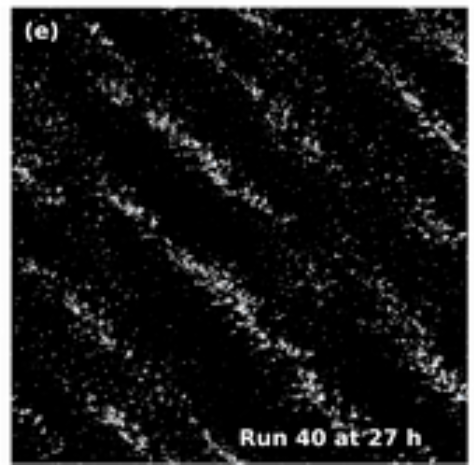

In [ ]:
# Figure 8 in the paper has 45 degree cloud bands, why? 
# Shear profile is not at 45 or anything

ds_u.u.sel(time='2020-02-02T03:00', member=40).plot()
ds_u.v.sel(time='2020-02-02T03:00', member=40).plot();

In [ ]:
# Plot mean buoyancy flux profiles at last time step 
ds_u['wthvt'].isel(time=-1).plot(size=2, aspect=1)

## Save the profile data to local disk

In [ ]:
ds_u.isel(time=slice(None, None, 10), zm=slice(None, None, 5))\
            .to_netcdf('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_profiles_103x72x35.nc')

-------------------
# 2D fields 

In [12]:
ds_2D = botany_cat.dx100m.nx1536['2D'].to_dask()
ds_2D

# check some problem cases 
# 1,9  31,11  34,8  47,8  61,3  69,4  74,7  81,4  83,4  86,4  91,5  
# Downloads have some missing squares since the wifi was unreliable during xarray .to_netcdf() method. 

<xarray.Dataset>
Dimensions:    (member: 103, time: 720, yt: 1536, xt: 1536)
Coordinates:
  * member     (member) int32 1 2 3 4 5 6 7 8 9 ... 96 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * xt         (xt) float64 50.0 150.0 250.0 ... 1.534e+05 1.534e+05 1.536e+05
  * yt         (yt) float64 50.0 150.0 250.0 ... 1.534e+05 1.534e+05 1.536e+05
Data variables:
    capemax    (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cinmax     (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cldtop     (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hinvsrf    (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hmix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    lwp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    rwp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    surfprec   (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    thetavmix  (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    twp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    umix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    vmix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 04:40:08 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/cape.x000y000.001.nc

In [197]:
# Vertical mean bflux 
bfluxts = ds_u['wthvt'].mean(dim='zm')

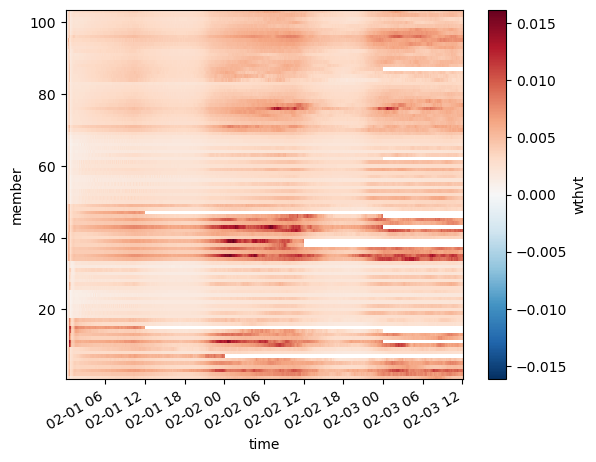

In [51]:
bfluxts.plot()

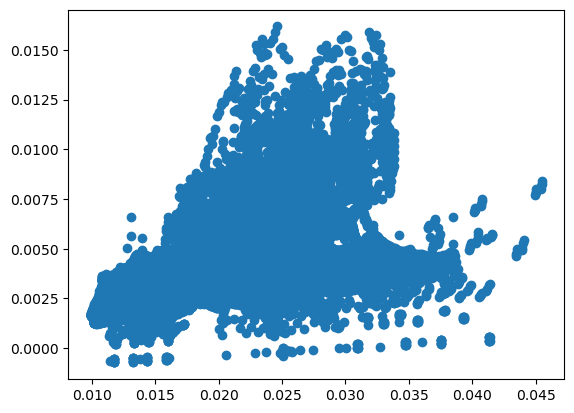

In [54]:
# Wonder if the surface value is a good proxy for the vertical mean? 
# Not necessarily, since buoyancy' is not really a conserved thing 
# depends on environment b' = g thv'/thv_env

plt.scatter( ds_u['wthvt'].isel(zm=1), bfluxts )

# 2D plots of cloud and rain patterns 

For the last time (60 hours after initialisation) for the “center” of the hypercube of simulation parameter space (member=1, the zeroth member), we could visualise the vertically integrated total specific humidity (the total water path twp), the cloud-top height (cldtop), the rain-water path (rwp) and an indicator for the extent of cold pools (the local mixed-layer height, hmix), as follows. 

To compute a suite of existing cloud scene morphometrics, one could follow [this repo](https://github.com/martinjanssens/cloudmetrics) although I have not done this

`import cloudmetrics`
`iorg = cloudmetrics.iorg(cloud_mask=da_cloudmask)`

In [184]:
ds2D = botany_cat.dx100m.nx1536['2D'].to_dask() #.sel(member=1).isel(time=-1)
ds2D

<xarray.Dataset>
Dimensions:    (member: 103, time: 720, yt: 1536, xt: 1536)
Coordinates:
  * member     (member) int32 1 2 3 4 5 6 7 8 9 ... 96 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * xt         (xt) float64 50.0 150.0 250.0 ... 1.534e+05 1.534e+05 1.536e+05
  * yt         (yt) float64 50.0 150.0 250.0 ... 1.534e+05 1.534e+05 1.536e+05
Data variables:
    capemax    (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cinmax     (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cldtop     (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hinvsrf    (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hmix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    lwp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    rwp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    surfprec   (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    thetavmix  (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    twp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    umix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    vmix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 04:40:08 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/cape.x000y000.001.nc

In [193]:
# Get column integral liquid and total water paths (cloud) and surface precip rate. 
# Subset every 6th spatial pixel and every 40th time level 

mydata2d = ds2D[ ['lwp','surfprec','twp'] ].isel(time=slice(None, None, 40))\
                                    .isel(xt=slice(None, None, 6))\
                                    .isel(yt=slice(None, None, 6)) 
mydata2d

<xarray.Dataset>
Dimensions:   (member: 103, time: 18, yt: 256, xt: 256)
Coordinates:
  * member    (member) int32 1 2 3 4 5 6 7 8 9 ... 96 97 98 99 100 101 102 103
  * time      (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T08:45:00
  * xt        (xt) float64 50.0 650.0 1.25e+03 ... 1.518e+05 1.524e+05 1.530e+05
  * yt        (yt) float64 50.0 650.0 1.25e+03 ... 1.518e+05 1.524e+05 1.530e+05
Data variables:
    lwp       (member, time, yt, xt) float32 dask.array<chunksize=(1, 1, 43, 43), meta=np.ndarray>
    surfprec  (member, time, yt, xt) float32 dask.array<chunksize=(1, 1, 43, 43), meta=np.ndarray>
    twp       (member, time, yt, xt) float32 dask.array<chunksize=(1, 1, 43, 43), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 04:40:08 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/cape.x000y000.001.nc

In [ ]:
# DOWNLOAD AND WRITE DATASET for offline work  
# exps: 103 time: 18  yt: 256  xt: 256    --> under 1GB

mydata2d.to_netcdf('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany_patterns256_goodwifi.nc')

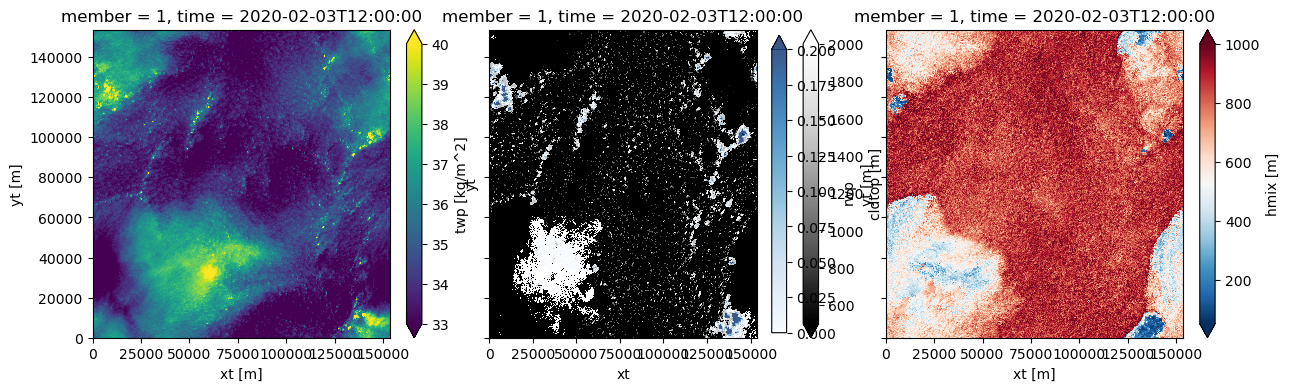

In [22]:
# Some example plots of one member at one time, from the example notebook at EUREC4a site
ds_2D = ds2D.sel(member=1).isel(time=-1)

cb_kw = {'fraction' : 0.05}
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(14.5,4))

# Total water path
ds_2D['twp'].plot(ax=axs[0], vmin=33 ,vmax=40, cbar_kwargs=cb_kw)

# Cloud-top height and rain water path
ds_2D['cldtop'].plot(ax=axs[1],cmap='Greys_r', vmin=500, vmax=2000, cbar_kwargs=cb_kw)
rwp_masked = xr.where(ds_2D['rwp'] > 1e-5, ds_2D['rwp'], np.nan)
rwp_masked.plot(ax=axs[1], cmap='Blues', vmin=0, vmax=0.2, alpha=0.8, cbar_kwargs=cb_kw)

# Mixed-layer height
ds_2D['hmix'].plot(ax=axs[2],cmap='RdBu_r', vmin=50, vmax=1000, cbar_kwargs=cb_kw)

plt.show()

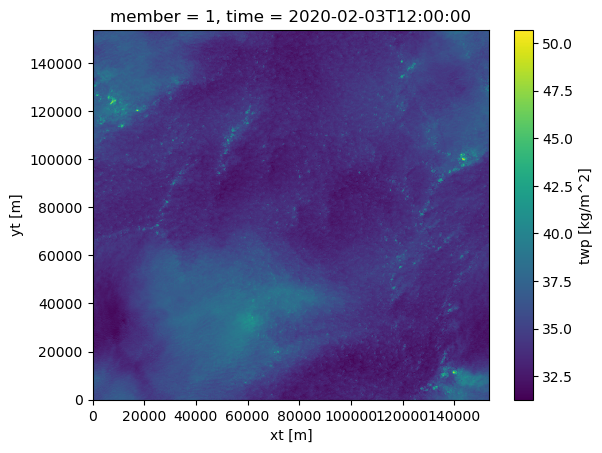

In [26]:
# Better view of LWP or TWP toward devising a cloud probability field 

ds_2D.twp.plot()

In [28]:
# Capture time series of basic stats: 103 members, 3600 times 

ds_ts = botany_cat.dx100m.nx1536['timeseries'].to_dask()
ds_ts

<xarray.Dataset>
Dimensions:  (member: 103, time: 3600)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
  * time     (time) datetime64[ns] 2020-02-01T00:01:00 ... 2020-02-03T12:00:00
Data variables: (12/22)
    cfrac    (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    lmax     (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    lwp_bar  (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    lwp_max  (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    obukh    (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    qtstr    (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    ...       ...
    wthetav  (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    z0       (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    zb       (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    zc_av    (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    zc_max   (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    zi       (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.345
    title:    tmser.001.nc

Text(0.5, 1.0, 'Cumulation of surface theta-v flux: a version of age')

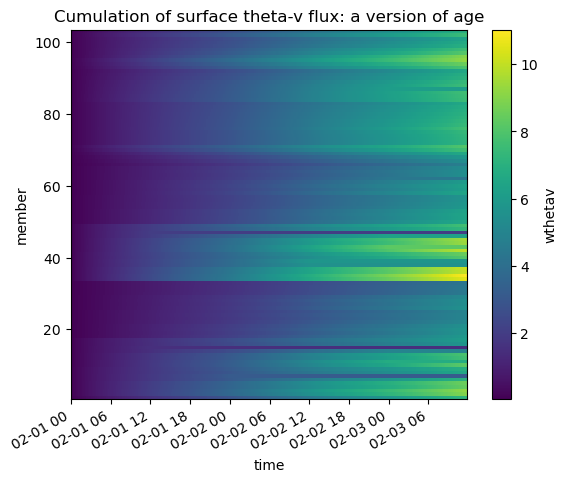

In [36]:
ds_ts.wthetav[:,::10].cumsum(axis=1).plot()
plt.title('Cumulation of surface theta-v flux: a version of age')

In [39]:
# Connect to huuuuge 'cross section' (map) data at 4 specific heights 

ds_crossxy = botany_cat.dx100m.nx1536['cross_xy'].to_dask()
ds_crossxy

<xarray.Dataset>
Dimensions:  (member: 103, zt: 4, time: 720, yt: 1536, xt: 1536, xm: 1536,
              ym: 1536)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
  * time     (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * xm       (xm) float64 0.0 100.0 200.0 ... 1.533e+05 1.534e+05 1.535e+05
  * xt       (xt) float64 50.0 150.0 250.0 ... 1.534e+05 1.534e+05 1.536e+05
  * ym       (ym) float64 0.0 100.0 200.0 ... 1.533e+05 1.534e+05 1.535e+05
  * yt       (yt) float64 50.0 150.0 250.0 ... 1.534e+05 1.534e+05 1.536e+05
  * zt       (zt) float32 7.5 197.7 611.4 999.1
Data variables:
    qlxy     (zt, member, time, yt, xt) float32 dask.array<chunksize=(1, 1, 32, 1536, 1536), meta=np.ndarray>
    qrxy     (zt, member, time, yt, xt) float32 dask.array<chunksize=(1, 1, 32, 1536, 1536), meta=np.ndarray>
    qtxy     (zt, member, time, yt, xt) float32 dask.array<chunksize=(1, 1, 32, 1536, 1536), meta=np.ndarray>
    thlxy    (zt, member, time, yt, xt) float32 dask.array<chunksize=(1, 1, 32, 1536, 1536), meta=np.ndarray>
    uxy      (zt, member, time, yt, xm) float32 dask.array<chunksize=(1, 1, 32, 1536, 1536), meta=np.ndarray>
    vxy      (zt, member, time, ym, xt) float32 dask.array<chunksize=(1, 1, 32, 1536, 1536), meta=np.ndarray>
    wxy      (zt, member, time, yt, xt) float32 dask.array<chunksize=(1, 1, 32, 1536, 1536), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 08:21:51 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/crossxy.0001.x000y000.001.nc

------------------

# Code to detect linear waves or cloud streets (Fourier analysis)

Not used in paper, but one could craft an information (nonuniformity-of-PDF) measure of this anisotropy, such as the azimuthal distribution of Fourier power at certain wavenumbers. That and precipitation and cumulative buoyancy flux could be 3 predictors of spatial field organization, for instance, or 3 ecological guilds interacting. Waves might be crucial in symmetry breaking, leading to cloud concentrations that might trigger precipitation, which then goes on to dominate the patterns? Future Work awaits, but pretty straightforward from these tools. 

In [27]:
ds2D = botany_cat.dx100m.nx1536['2D'].to_dask() #.sel(member=1).isel(time=-1)
ds2D

<xarray.Dataset>
Dimensions:    (member: 103, time: 720, yt: 1536, xt: 1536)
Coordinates:
  * member     (member) int32 1 2 3 4 5 6 7 8 9 ... 96 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * xt         (xt) float64 50.0 150.0 250.0 ... 1.534e+05 1.534e+05 1.536e+05
  * yt         (yt) float64 50.0 150.0 250.0 ... 1.534e+05 1.534e+05 1.536e+05
Data variables:
    capemax    (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cinmax     (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cldtop     (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hinvsrf    (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hmix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    lwp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    rwp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    surfprec   (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    thetavmix  (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    twp        (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    umix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    vmix       (member, time, yt, xt) float32 dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 04:40:08 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/cape.x000y000.001.nc

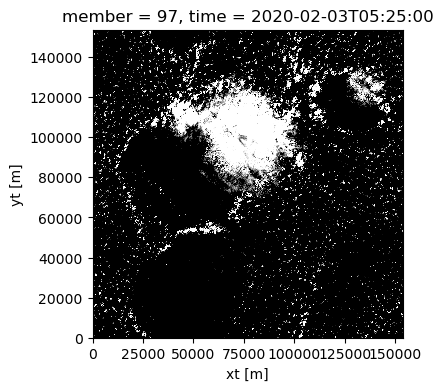

In [213]:
# Detect wave direction and amplitude, find an example where it is clear 
# like member=4, time=250    [3][250] 
# sqrt helps bring up small values, crushes dynamic range (as does radiative impact!) 

np.sqrt(ds2D.lwp[96][16*40]).plot(vmin=0, vmax=0.25, cmap='Greys_r', add_colorbar=False, size=4, aspect=1)

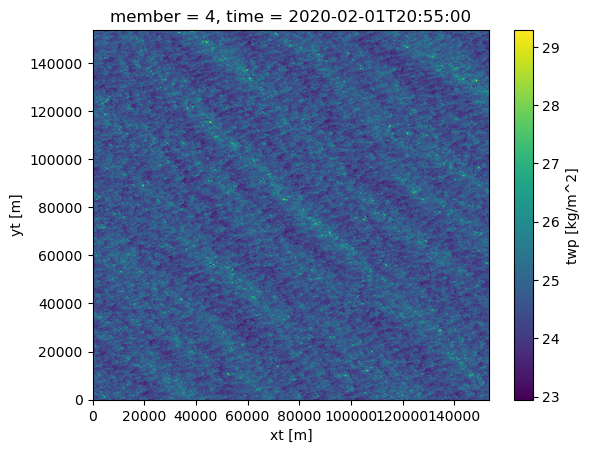

In [153]:
# total water path example with strong wave signature 
ds2D.twp[3][250].plot()

In [154]:
# TWP image: let's process one 

image = np.sqrt(ds2D.twp[3][250]) 
cloud_pattern = image.values

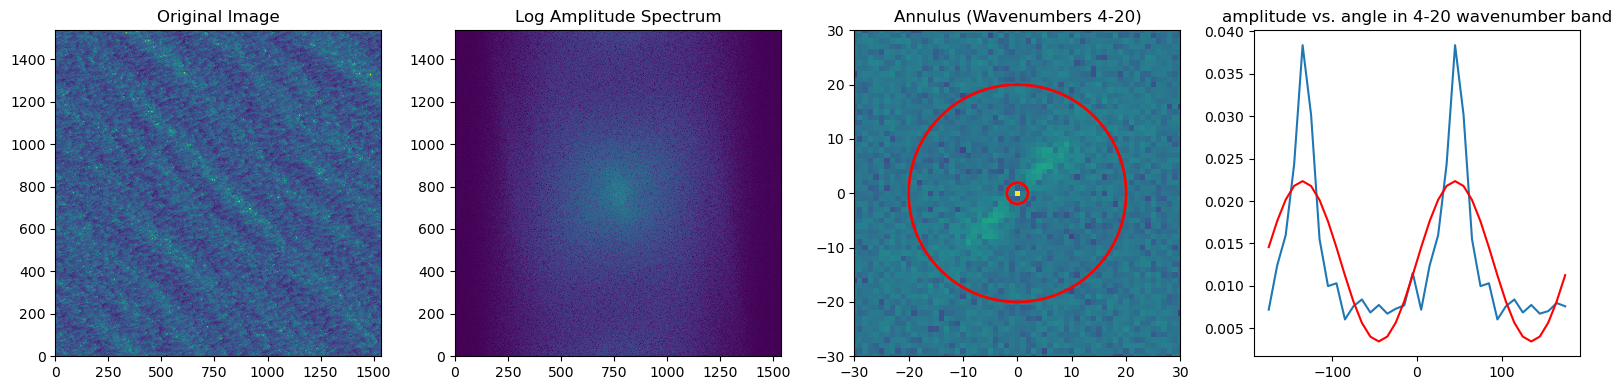

angle is  4 -2.442303546038751 -134.9378126012972 45.062187398702804
strength is  2.9772959441418694


In [183]:
# FFT2 to identify horizontal wavenumber vector 
# ChatGPT wrote this code and I tested/adapted from there 

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from scipy.optimize import curve_fit

# Generate a sample image (replace this with your cloud probability distribution)
image_size = cloud_pattern.shape[0]

# Apply Fourier Transform
fft_result = fft2(cloud_pattern)

# Shift zero frequency components to the center
fft_result_shifted = fftshift(fft_result)

# Calculate amplitude
amplitude = np.abs(fft_result_shifted)


# Create 2D wavenumber array
kx = np.fft.fftshift(np.fft.fftfreq(image_size, d=1/image_size)) 
ky = np.fft.fftshift(np.fft.fftfreq(image_size, d=1/image_size))
kx, ky = np.meshgrid(kx, ky)

# Calculate total wavenumber array
wavenumbers = np.sqrt(kx**2 + ky**2)


# Calculate the polar coordinates
radius = np.sqrt(kx**2 + ky**2)
theta = np.arctan2(ky, kx)

# Average the amplitude where the TOTAL wavenumber is between 4 and 20
min_wavenumber = 2
max_wavenumber = 20
in_k_range = (radius>min_wavenumber) & (radius<max_wavenumber)


# Create theta bins
num_bins = 36  # 10 degrees each bin 
theta_bins = np.linspace(np.min(theta), np.max(theta), num_bins + 1)

# Calculate the mean amplitude in each theta bin
mean_amplitude = np.zeros(num_bins)
for i in range(num_bins):
    in_bin = (theta >= theta_bins[i]) & (theta < theta_bins[i + 1])
    mean_amplitude[i] = np.mean(amplitude * in_k_range * in_bin)


# -------- chatGPT fits it, although really just argmax and max-mean suffices 
# Define the bisinusoidal fit function
def bisinusoidal_fit(theta, amplitude, phase, offset):
    return amplitude * np.sin(2*theta + phase) + offset

# Initial guess for the fit parameters
initial_guess = [1.0, 0.0, 0.0]

# Fit the sinusoidal curve to the azimuthal variation
popt, _ = curve_fit(bisinusoidal_fit, theta_bins[:-1], mean_amplitude, p0=initial_guess)
# ------------


# Plot the original image, amplitude, the annulus, and the fitted sinusoidal curve
plt.figure(figsize=(16, 4))

plt.subplot(141)
plt.pcolormesh(cloud_pattern, cmap='viridis')
plt.title('Original Image')

plt.subplot(142)
plt.pcolormesh(np.log1p(amplitude), cmap='viridis')
plt.title('Log Amplitude Spectrum')

plt.subplot(143)
plt.pcolormesh(kx,ky, np.log1p(amplitude), cmap='viridis')
ax = plt.gca()
ax.set_xlim([-30, 30])
ax.set_ylim([-30, 30])
plt.contour(kx,ky,radius, levels=[min_wavenumber, max_wavenumber], colors='r', linewidths=2)
plt.title('Annulus (Wavenumbers 4-20)')

plt.subplot(144)
plt.plot(theta_bins[:-1] *180/3.1415 + 360/num_bins/2, mean_amplitude)
plt.title('amplitude vs. angle in 4-20 wavenumber band')
plt.plot(theta_bins[:-1] *180/3.1415 + 360/num_bins/2, sinusoidal_fit(2*theta_bins[:-1], *popt), 'r-', label='Sinusoidal Fit')

plt.plot() 

plt.tight_layout()
plt.show()


argmx = np.argmax(mean_amplitude)
maxangle = theta_bins[ argmx ]
maxangledeg = theta_bins[ argmx ] *180/3.1415 + 360/num_bins/2

print('angle is ', argmx, maxangle, maxangledeg, maxangledeg+180)
print('strength is ',np.max(mean_amplitude)/np.mean(mean_amplitude) )

# Print the fitted parameters
#amplitude_fit, phase_fit, offset_fit = popt
#print(f"Amplitude of the Fit: {amplitude_fit}")
#print(f"Phase of the Fit: {phase_fit*1800./3.142}")
#print(f"Offset of the Fit: {offset_fit}")


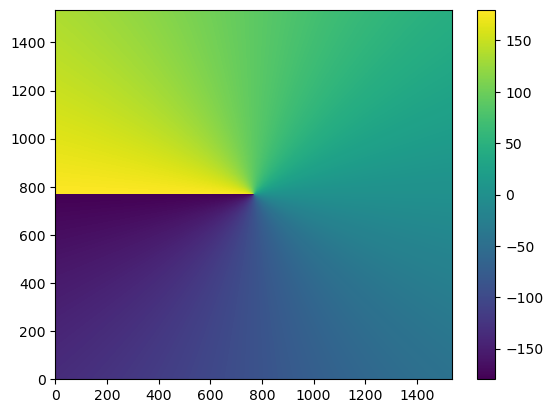

In [149]:
plt.pcolormesh(theta*180./3.1415); plt.colorbar();